In [1]:
# ============================================================================
# Author: pf.zh
# Date: 2024-12-15
# ============================================================================

import numpy as np
from collections import defaultdict

def euclidean_distance(x, y):
    """
    计算两个数据点间的欧氏距离
    """
    return np.linalg.norm(np.array(x) - np.array(y))

def find_neighbors(X, x, eps):
    """
    计算并返回点x在数据集X中eps邻域范围内的所有点
    """
    # 存储x的邻域点
    neighbors = []
    # 遍历数据集X中的每一个点，计算与x的欧氏距离
    for nx in X:
        if not np.array_equal(x, nx) and euclidean_distance(x, nx) <= eps:
            neighbors.append(nx)
    return neighbors

def find_core_points(X, eps, minPts):
    """
    获取数据集X中的所有核心点及其成员
    """
    core_point_map = {}
    for x in X:
        neighbors = find_neighbors(X, x, eps)
        if len(neighbors) >= minPts:
            core_point_map[tuple(x)] = neighbors
    return core_point_map

def convert_to_tuples(two_dim_list):
    """
    将二维列表中的每个元素转换为元组
    """
    return [tuple(inner_list) for inner_list in two_dim_list]

In [2]:
import random

def DBSCAN(X, eps, minPts):
    """
    DBSCAN密度聚类算法
    """
    # 聚类结果与类别标签
    clustering_map, label = defaultdict(set), 0
    
    # 获取所有核心点
    core_point_map = find_core_points(X, eps, minPts)
    core_points = list(core_point_map.keys())
    
    # 遍历核心点，直至不存在未访问的核心点为止
    while len(core_points) != 0:
        # 随机选择核心点
        core_point = random.choice(core_points)
        # 访问即删除，防止重复访问
        core_points.remove(core_point)
        # 查找该核心点的邻居
        neighbors = core_point_map.get(core_point)
        
        # 对于该核心点代表的簇，其自身与邻居必然为同一个簇，划分进去
        clustering_map[label] = clustering_map[label].union([core_point] + neighbors)
        # 更新未访问的样本集合
        X = list(set(X) - set(clustering_map[label]))
        
        # 接下来由core_point的邻居开始向外扩展 -> 以核心点为主线扩展邻居集合
        while len(neighbors) != 0:
            # 弹出邻居集合的第一个元素
            neighbor = neighbors.pop(0)
            neighbor_neighbors = core_point_map.get(neighbor)
            # 如果找到了核心点
            if neighbor_neighbors is not None:
                # 由于该核心点已访问，因此直接删除防止重复访问
                core_points.remove(neighbor)
                # 由于该核心点的（部分）邻居可能也属于已被访问的其余核心点的邻居，有可能已经被划分，因此需要得到还未被划分的邻居集合
                rest = set(neighbor_neighbors).intersection(set(X))
                # 未被划分的邻居集合中可能还有核心点，因此拓展邻居集合
                neighbors += list(rest)
                # 划分
                clustering_map[label] = clustering_map[label].union(rest)
                # 更新未访问样本集合
                X = list(set(X) - rest)
        # 更新簇标识
        label += 1
    # 返回划分结果与噪声点
    return clustering_map, X

In [42]:
from sklearn.datasets import make_blobs, make_moons, make_circles

# 1. 使用 make_blobs 生成数据集
X_blobs, _ = make_blobs(n_samples=300, centers=3, cluster_std=0.60, random_state=42)

# 2. 使用 make_moons 生成数据集
X_moons, _ = make_moons(n_samples=300, noise=0.1, random_state=42)

# 3. 使用 make_circles 生成数据集
X_circles, _ = make_circles(n_samples=300, noise=0.1, factor=0.3, random_state=42)

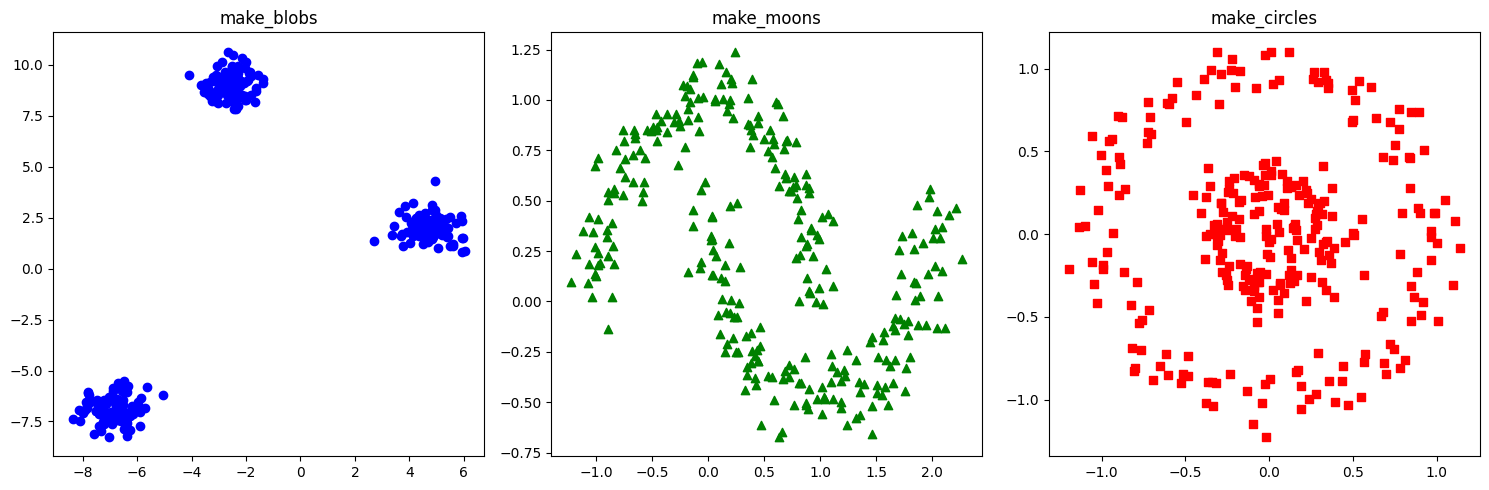

In [43]:
import matplotlib.pyplot as plt

# 绘制数据集
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# 绘制 make_blobs 数据
ax[0].scatter(X_blobs[:, 0], X_blobs[:, 1], c='blue', marker='o')
ax[0].set_title('make_blobs')

# 绘制 make_moons 数据
ax[1].scatter(X_moons[:, 0], X_moons[:, 1], c='green', marker='^')
ax[1].set_title('make_moons')

# 绘制 make_circles 数据
ax[2].scatter(X_circles[:, 0], X_circles[:, 1], c='red', marker='s')
ax[2].set_title('make_circles')

plt.tight_layout()
plt.show()

In [46]:
res_blobs, _ = DBSCAN(convert_to_tuples(X_blobs), 1, 3)

In [47]:
res_moons, _ = DBSCAN(convert_to_tuples(X_moons), 0.2, 3)

In [48]:
res_circles, _ = DBSCAN(convert_to_tuples(X_circles), 0.2, 3)

/var/folders/l9/7x451g6n2y91ptkr7k4fy6fr0000gn/T/ipykernel_38766/787884151.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[0].scatter(points[:, 0], points[:, 1], marker='o', cmap='viridis', label=f'Cluster {cluster_id}')
/var/folders/l9/7x451g6n2y91ptkr7k4fy6fr0000gn/T/ipykernel_38766/787884151.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[1].scatter(points[:, 0], points[:, 1], marker='^', cmap='viridis', label=f'Cluster {cluster_id}')
/var/folders/l9/7x451g6n2y91ptkr7k4fy6fr0000gn/T/ipykernel_38766/787884151.py:20: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax[2].scatter(points[:, 0], points[:, 1], marker='s', cmap='viridis', label=f'Cluster {cluster_id}')


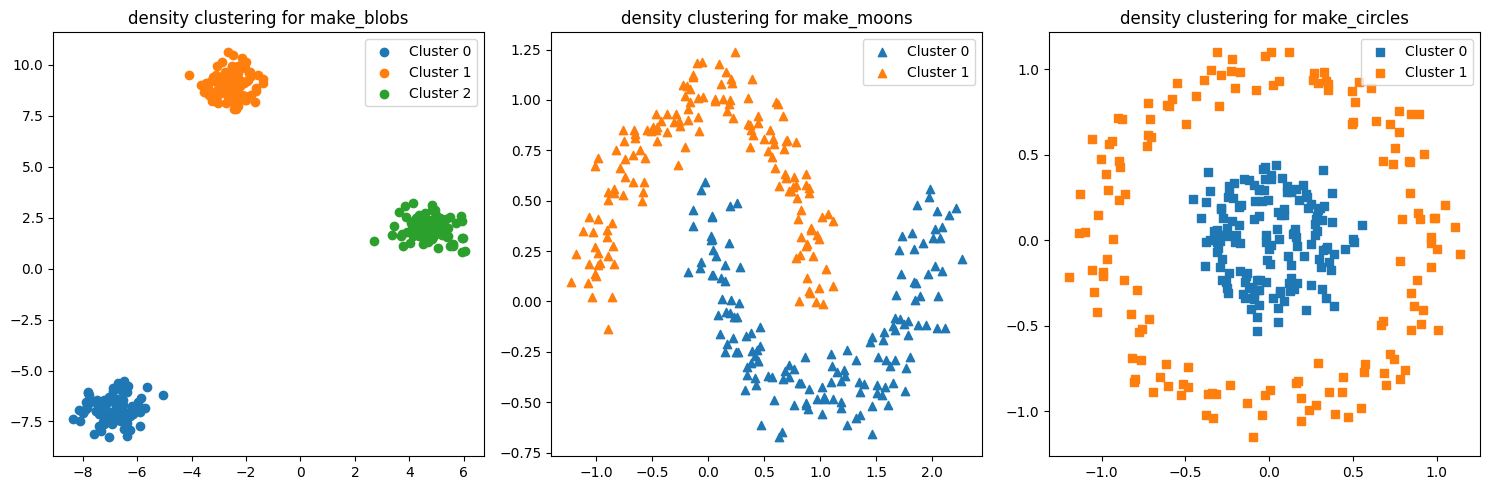

In [53]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# 绘制每个簇的数据点
for i, (cluster_id, points) in enumerate(res_blobs.items()):
    points = np.array(list(points))  # 将集合转换为数组
    ax[0].scatter(points[:, 0], points[:, 1], marker='o', cmap='viridis', label=f'Cluster {cluster_id}')
ax[0].set_title('density clustering for make_blobs')
ax[0].legend()

# 绘制每个簇的数据点
for i, (cluster_id, points) in enumerate(res_moons.items()):
    points = np.array(list(points))  # 将集合转换为数组
    ax[1].scatter(points[:, 0], points[:, 1], marker='^', cmap='viridis', label=f'Cluster {cluster_id}')
ax[1].set_title('density clustering for make_moons')
ax[1].legend()

# 绘制每个簇的数据点
for i, (cluster_id, points) in enumerate(res_circles.items()):
    points = np.array(list(points))  # 将集合转换为数组
    ax[2].scatter(points[:, 0], points[:, 1], marker='s', cmap='viridis', label=f'Cluster {cluster_id}')
ax[2].set_title('density clustering for make_circles')
ax[2].legend()

plt.tight_layout()
plt.show()